# Project - Option 1

## Task 1

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import numpy as np
import os
import sys
import pandas as pd

In [3]:
appName = "Big Data Analytics"
master = "local[*]"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
 .set('spark.driver.host','127.0.0.1')\
   .setAppName(appName)\
    .setMaster(master)

spark = SparkSession.builder.config(conf = conf).getOrCreate()

In [4]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="systems"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']="fifa.fifa"
db_properties['driver']="org.postgresql.Driver"

In [15]:
df_male = spark.read.csv('./Data/players_15.csv', header = True)
combined_df = df_male.withColumn("year", lit(2015))
combined_df = combined_df.withColumn("record_id", monotonically_increasing_id()).select("record_id", *combined_df.columns)
combined_df = combined_df.withColumn("gender", lit("Male"))
folder_path = "./Data"
for file_name in os.listdir(folder_path):
    if file_name == "players_15.csv":
        continue
    year = "20" + file_name[-6:-4]
    file_path = os.path.join(folder_path, file_name)
    df_read = spark.read.csv(file_path, header = True)
    df_read = df_read.withColumn("year", lit(int(year)))
    df_read = df_read.withColumn("record_id", monotonically_increasing_id()).select("record_id", *df_read.columns)
    if "female" in file_name:
        df_read = df_read.withColumn("gender", lit("Female"))
    else:
        df_read = df_read.withColumn("gender", lit("Male"))
    combined_df = combined_df.union(df_read)

In [16]:
# Write to PostgreSQL
combined_df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [4]:
# Read from PostgreSQL to verify
df_from_postgres = spark.read \
    .format("jdbc") \
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

In [ ]:
df_from_postgres.columns

['record_id',
 'sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',


In [6]:
df_from_postgres.count()

144323

## Task 2

In [5]:
def read_from_spark(spark, db_properties):
    df_from_postgres = spark.read \
        .format("jdbc") \
        .option("url", db_properties['url'])\
        .option("dbtable", db_properties['table'])\
        .option("user", db_properties['username'])\
        .option("password", db_properties['password'])\
        .option("Driver", db_properties['driver'])\
        .load()
    df = df_from_postgres.filter(df_from_postgres["gender"] == "Male")
    return df

In [8]:
def get_top_clubs_with_contracts_ending(spark, db_properties, X, Y, Z):
    df = read_from_spark(spark, db_properties)
    df_filtered = df.filter(col("year") == X)
    df_expiring = df_filtered.filter(col("club_contract_valid_until").cast("int") >= Z)
    result = df_expiring.groupBy("club_name") \
        .count() \
        .orderBy(col("count").desc()) \
        .limit(Y)
    return result.collect()

In [9]:
def find_clubs_by_average_age(spark, db_properties, X, Y, highest=True):
    if X <= 0:
        return "X must be a positive integer"
    if Y < 2015 or Y > 2022:
        return "Y must be a year between 2015 and 2022 inclusively"
    df = read_from_spark(spark, db_properties)
    
    # Filter data for specified year Y
    df_filtered = df.filter(col("year") == Y)
    avg_age_per_club = df_filtered.groupBy("club_name") \
        .agg(round(avg("age").cast("float"),2).alias("average_age"))
    if highest:
        sorted_clubs = avg_age_per_club.orderBy(desc("average_age"))
    else:
        sorted_clubs = avg_age_per_club.orderBy(asc("average_age"))

    top_clubs = sorted_clubs.limit(X)
    last_club = top_clubs.collect()[-1]
    threshold_age = last_club["average_age"]
    if highest:
        result_clubs = sorted_clubs.filter(col("average_age") >= threshold_age).collect()
    else:
        result_clubs = sorted_clubs.filter(col("average_age") <= threshold_age).collect()
    return result_clubs

In [10]:
def get_most_popular_nationality(spark, db_properties):
    df = read_from_spark(spark, db_properties)
    # df_filtered = df.filter((col("year") >= 2015) & (col("year") <= 2022))
    nationality_counts = df.groupBy("year", "nationality_name") \
        .agg(count("*").alias("count"))
    # Create a window partitioned by year and ordered by count descending
    window = Window.partitionBy("year").orderBy(desc("count"))
    
    # Add row number within each year partition
    ranked_nationalities = nationality_counts.withColumn("rank", row_number().over(window))
    # Filter for the top nationality for each year
    most_popular_nationalities = ranked_nationalities.filter(col("rank") == 1) \
        .select("year", "nationality_name", "count") \
        .orderBy("year")
    
    return most_popular_nationalities.collect()

## Task-2.1

In [11]:
top_clubs = get_top_clubs_with_contracts_ending(spark=spark, db_properties=db_properties, X=2021, Y=10, Z=2023)

In [12]:
top_clubs

[Row(club_name='GwangJu FC', count=28),
 Row(club_name='Zamora Fútbol Club', count=27),
 Row(club_name='Club Plaza de Deportes Colonia', count=27),
 Row(club_name='Gangwon FC', count=26),
 Row(club_name='Sociedad Deportiva Aucas', count=26),
 Row(club_name='SL Benfica', count=26),
 Row(club_name='Club Atlético Nacional Potosí', count=26),
 Row(club_name='Club Deportivo El Nacional', count=26),
 Row(club_name='Busan IPark', count=26),
 Row(club_name='Club Social, Cultural y Deportivo de Blooming', count=25)]

<h1>Task-2.2</h1>

In [13]:
clubs_by_age = find_clubs_by_average_age(spark=spark, db_properties=db_properties, X=10, Y=2017, highest=False)

In [14]:
clubs_by_age

[Row(club_name='Sevilla Atlético', average_age=19.920000076293945),
 Row(club_name='Swindon Town', average_age=21.3700008392334),
 Row(club_name='CD Huachipato', average_age=21.40999984741211),
 Row(club_name='FC Nordsjælland', average_age=21.40999984741211),
 Row(club_name='FC Twente', average_age=21.59000015258789),
 Row(club_name='Envigado FC', average_age=21.610000610351562),
 Row(club_name='KRC Genk', average_age=21.6299991607666),
 Row(club_name='Crewe Alexandra', average_age=21.81999969482422),
 Row(club_name='Barnsley', average_age=21.8700008392334),
 Row(club_name='Ajax', average_age=21.969999313354492)]

<h1>Task-2.3</h1>

In [15]:
popular_nationalities = get_most_popular_nationality(spark=spark, db_properties=db_properties)

In [16]:
popular_nationalities

[Row(year=2015, nationality_name='England', count=1627),
 Row(year=2016, nationality_name='England', count=1519),
 Row(year=2017, nationality_name='England', count=1627),
 Row(year=2018, nationality_name='England', count=1633),
 Row(year=2019, nationality_name='England', count=1625),
 Row(year=2020, nationality_name='England', count=1670),
 Row(year=2021, nationality_name='England', count=1685),
 Row(year=2022, nationality_name='England', count=1719)]

# Task III

In [27]:
#Setup column categories
col_names = ['record_id',
 'sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'goalkeeping_speed',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm',
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm',
 'rwb',
 'lb',
 'lcb',
 'cb',
 'rcb',
 'rb',
 'gk',
 'player_face_url',
 'club_logo_url',
 'club_flag_url',
 'nation_logo_url',
 'nation_flag_url',
 'year',
 'gender']

ordinal_cols = ['work_rate', 'body_type']
continuous_cols = ['potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id',
                   'league_level', 'weak_foot', 'skill_moves', 'international_reputation',
                   'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
                   'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
                   'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance',
                   'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                   'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                   'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
                   'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']

skills_cols = ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control']

position_cols = ['player_positions', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
                   'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

columns_to_drop = ['record_id', 'sofifa_id', 'player_url', 'short_name', 'long_name',
                   'dob', 'club_name', 'league_name', 'club_position', 'club_jersey_number', 'club_loaned_from',
                   'club_joined','club_contract_valid_until', 'nationality_id', 'nationality_name', 'nation_team_id',
                   'nation_position', 'nation_jersey_number', 'real_face', 'player_tags', 'player_traits', 
                   'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url',
                   'year', 'gender']

null_cols_drop = ['release_clause_eur']

corr_cols_drop = ['movement_acceleration', 'preferred_foot']

dropped_null_rows = ['value_eur', 'wage_eur', 'goalkeeping_speed']

In [28]:
print(len(ordinal_cols) + len(continuous_cols))

47


In [18]:
df = read_from_spark(spark, db_properties)

In [55]:
for col in ordinal_cols:
    print(col)
    print(df.select(col).distinct().count())

work_rate
9
body_type
10


In [44]:
df.show()

+-----------+---------+--------------------+---------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+--------------------+--------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+-----------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------

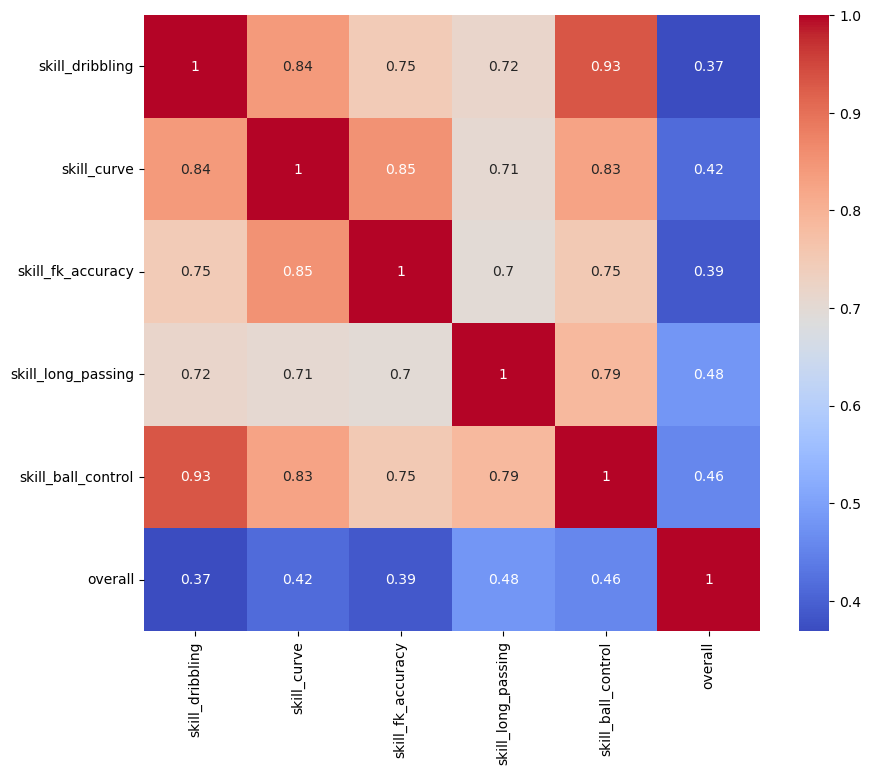

In [8]:
import seaborn as sb
import matplotlib.pyplot as plt

#Take average
compare_df = df.select('skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'overall').toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

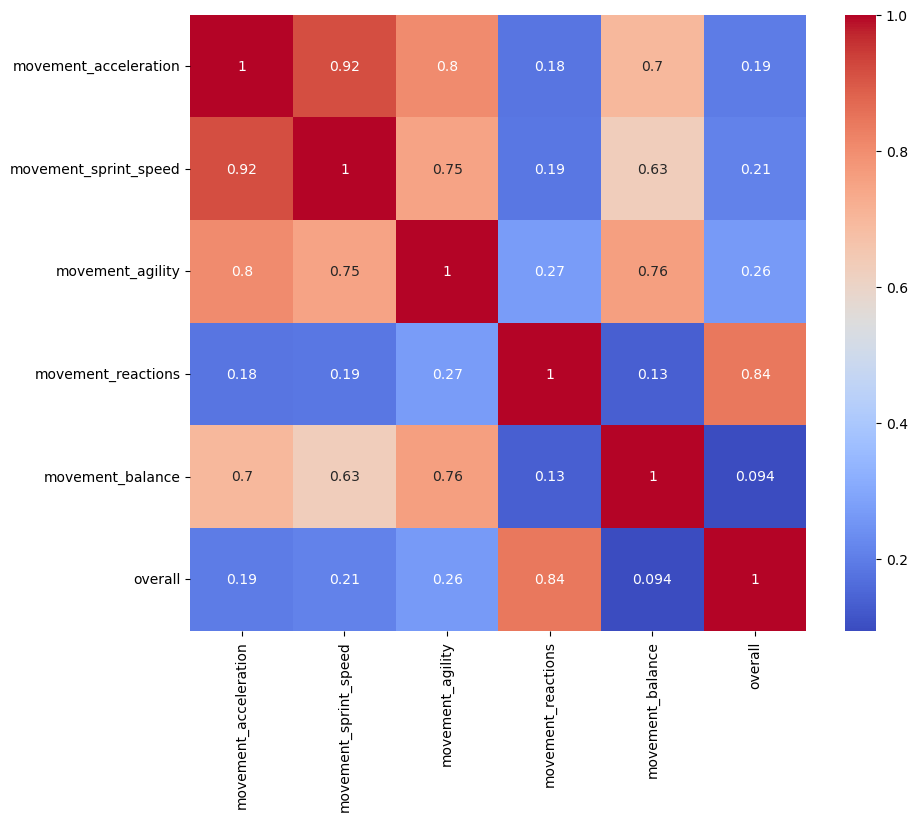

In [ ]:
#Drop movement_acceleration
compare_df = df.select('movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'overall').toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

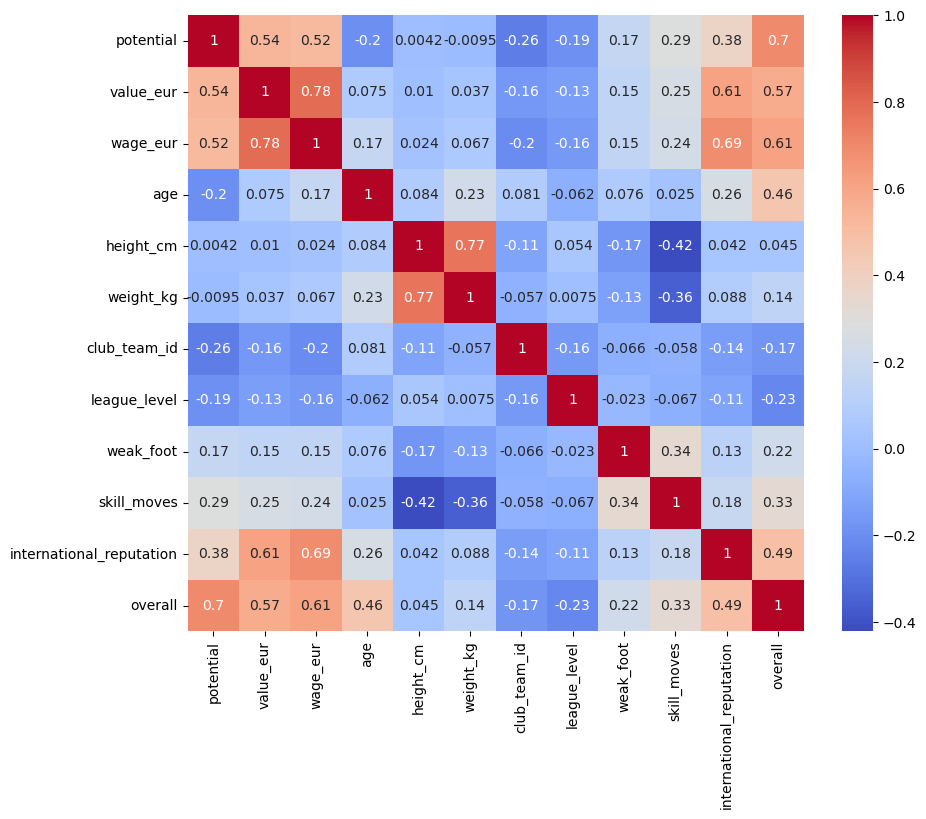

In [28]:
compare_df = df.select('potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id',
                       'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'overall').toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

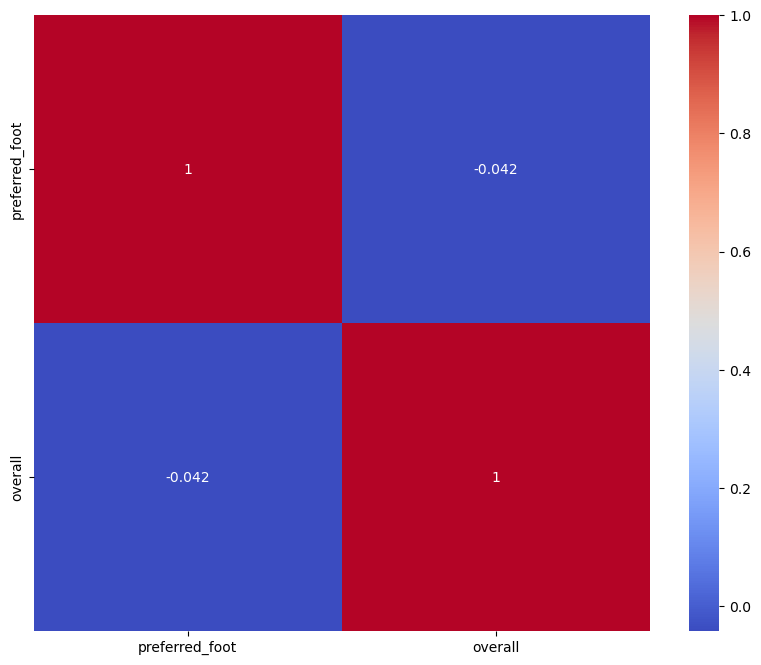

In [ ]:
#Drop preferred_foot as not correlated with overall score
compare_df = df.select('preferred_foot', 'overall').toPandas()
compare_df['preferred_foot'] = compare_df['preferred_foot'].map({'Left': 0, 'Right': 1})
compare_df = compare_df.dropna()
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

In [23]:
df.select('preferred_foot').show()

+--------------+
|preferred_foot|
+--------------+
|          Left|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|          Left|
|         Right|
|          Left|
+--------------+
only showing top 20 rows



In [43]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df, continuous_cols):
    # Identifying the numerical columns in a spark dataframe

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in continuous_cols:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [46]:
# assuming 'df' is your DataFrame and 'column1', 'column2' are the columns you want to cast as double
for column in continuous_cols:
    df = df.withColumn(column, col(column).cast("double"))

df_outliers = find_outliers(df, continuous_cols)

In [51]:
outlier = df_outliers.groupby("total_outliers").count().sort(col("total_outliers").asc()).show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             0|58659|
|             1|43091|
|             2|13244|
|             3| 7119|
|             4| 3496|
|             5|  993|
|             6| 1514|
|             7| 2836|
|             8| 3172|
|             9| 3022|
|            10| 2083|
|            11| 1461|
|            12|  853|
|            13|  365|
|            14|  141|
|            15|   27|
|            16|    2|
|            17|    1|
+--------------+-----+



In [ ]:
df_no_outliers = df_outliers.filter(df_outliers['total_Outliers']<=8)
print(df_no_outliers.count())